# Imports

In [ ]:
#!pip install catboost

In [29]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_columns', None)

# Read diamonds

In [30]:
diamonds_train_sorted = pd.read_csv('../data/diamonds_train_sorted.csv')
diamonds_train_sorted.head()

,price,carat,cut,color,clarity,depth,table,x,y,z
0,326,0.21,3,5,2,59.8,61.0,3.89,3.84,2.31
1,326,0.23,4,5,1,61.5,55.0,3.95,3.98,2.43
2,327,0.23,1,5,4,56.9,65.0,4.05,4.07,2.31
3,334,0.29,3,1,3,62.4,58.0,4.20,4.23,2.63
4,335,0.31,1,0,1,63.3,58.0,4.34,4.35,2.75


# Feature engineering

In [31]:
#diamonds_train_sorted['table_xy'] = (diamonds_train_sorted['table'].mean()*(diamonds_train_sorted['x']*diamonds_train_sorted['y']).mean()-diamonds_train_sorted['table']*(diamonds_train_sorted['x']*diamonds_train_sorted['y']))
#diamonds_train_sorted['depth_z'] = (diamonds_train_sorted['depth'].mean()*diamonds_train_sorted['z'].mean()-diamonds_train_sorted['depth']*diamonds_train_sorted['z'])
#diamonds_train_sorted['volume'] = diamonds_train_sorted['x']*diamonds_train_sorted['y']*diamonds_train_sorted['z']
#diamonds_train_sorted['super_feature'] = diamonds_train_sorted['carat'] / diamonds_train_sorted['table'] * diamonds_train_sorted['depth']
#diamonds_train_sorted['super_feature'] = (2*diamonds_train_sorted['z'])/(diamonds_train_sorted['x']+diamonds_train_sorted['y'])
#diamonds_train_sorted['dtc'] = diamonds_train_sorted['depth'] / diamonds_train_sorted['table'] * diamonds_train_sorted['carat']
diamonds_train_sorted['ratio_length_width'] = diamonds_train_sorted['x']/diamonds_train_sorted['y']
diamonds_train_sorted.head()

,price,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width
0,326,0.21,3,5,2,59.8,61.0,3.89,3.84,2.31,1.013021
1,326,0.23,4,5,1,61.5,55.0,3.95,3.98,2.43,0.992462
2,327,0.23,1,5,4,56.9,65.0,4.05,4.07,2.31,0.995086
3,334,0.29,3,1,3,62.4,58.0,4.20,4.23,2.63,0.992908
4,335,0.31,1,0,1,63.3,58.0,4.34,4.35,2.75,0.997701


In [32]:
carat_log= []
for i in diamonds_train_sorted['carat']:
    carat_log.append(math.log(i))
diamonds_train_sorted['carat_log'] = carat_log
diamonds_train_sorted.head()

,price,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width,carat_log
0,326,0.21,3,5,2,59.8,61.0,3.89,3.84,2.31,1.013021,-1.560648
1,326,0.23,4,5,1,61.5,55.0,3.95,3.98,2.43,0.992462,-1.469676
2,327,0.23,1,5,4,56.9,65.0,4.05,4.07,2.31,0.995086,-1.469676
3,334,0.29,3,1,3,62.4,58.0,4.20,4.23,2.63,0.992908,-1.237874
4,335,0.31,1,0,1,63.3,58.0,4.34,4.35,2.75,0.997701,-1.171183


# Create diamond shape

In [33]:
shape = []
for i in diamonds_train_sorted['table'].index:
    if 54<diamonds_train_sorted['table'][i]<57 and 59<diamonds_train_sorted['depth'][i]<62.6:
        shape.append('Round')
    elif diamonds_train_sorted['table'][i]<68 and 61<diamonds_train_sorted['depth'][i]<68:
        shape.append('Cushion')
    elif 69<diamonds_train_sorted['table'][i]<75 and 68<diamonds_train_sorted['depth'][i]<74:
        shape.append('Princess')
    elif 60<diamonds_train_sorted['table'][i]<68 and 61<diamonds_train_sorted['depth'][i]<68:
        shape.append('Emerald')    
    elif 53<diamonds_train_sorted['table'][i]<65 and diamonds_train_sorted['depth'][i]<68:
        shape.append('Oval')
    elif 61<diamonds_train_sorted['table'][i]<69 and diamonds_train_sorted['depth'][i]<67:
        shape.append('Radiant')
    elif 53<diamonds_train_sorted['table'][i]<63 and 56<diamonds_train_sorted['depth'][i]<62:
        shape.append('Heart')   
    else:
        shape.append('others')

In [34]:
diamonds_train_sorted['shape'] = shape
diamonds_train_sorted.head()

,price,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width,carat_log,shape
0,326,0.21,3,5,2,59.8,61.0,3.89,3.84,2.31,1.013021,-1.560648,Oval
1,326,0.23,4,5,1,61.5,55.0,3.95,3.98,2.43,0.992462,-1.469676,Round
2,327,0.23,1,5,4,56.9,65.0,4.05,4.07,2.31,0.995086,-1.469676,Radiant
3,334,0.29,3,1,3,62.4,58.0,4.20,4.23,2.63,0.992908,-1.237874,Cushion
4,335,0.31,1,0,1,63.3,58.0,4.34,4.35,2.75,0.997701,-1.171183,Cushion


# Shape label encoding 

In [35]:
diamonds_train_sorted['shape']=diamonds_train_sorted['shape'].map({'Round':7, 'Cushion':6, 'Princess': 5, 
                                                     'Emerald':4,'Oval': 3, 'Radiant': 2,
                                                  'Heart': 1, 'others':0})
diamonds_train_sorted.head()

,price,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width,carat_log,shape
0,326,0.21,3,5,2,59.8,61.0,3.89,3.84,2.31,1.013021,-1.560648,3
1,326,0.23,4,5,1,61.5,55.0,3.95,3.98,2.43,0.992462,-1.469676,7
2,327,0.23,1,5,4,56.9,65.0,4.05,4.07,2.31,0.995086,-1.469676,2
3,334,0.29,3,1,3,62.4,58.0,4.20,4.23,2.63,0.992908,-1.237874,6
4,335,0.31,1,0,1,63.3,58.0,4.34,4.35,2.75,0.997701,-1.171183,6


# Correlation

<Axes: >

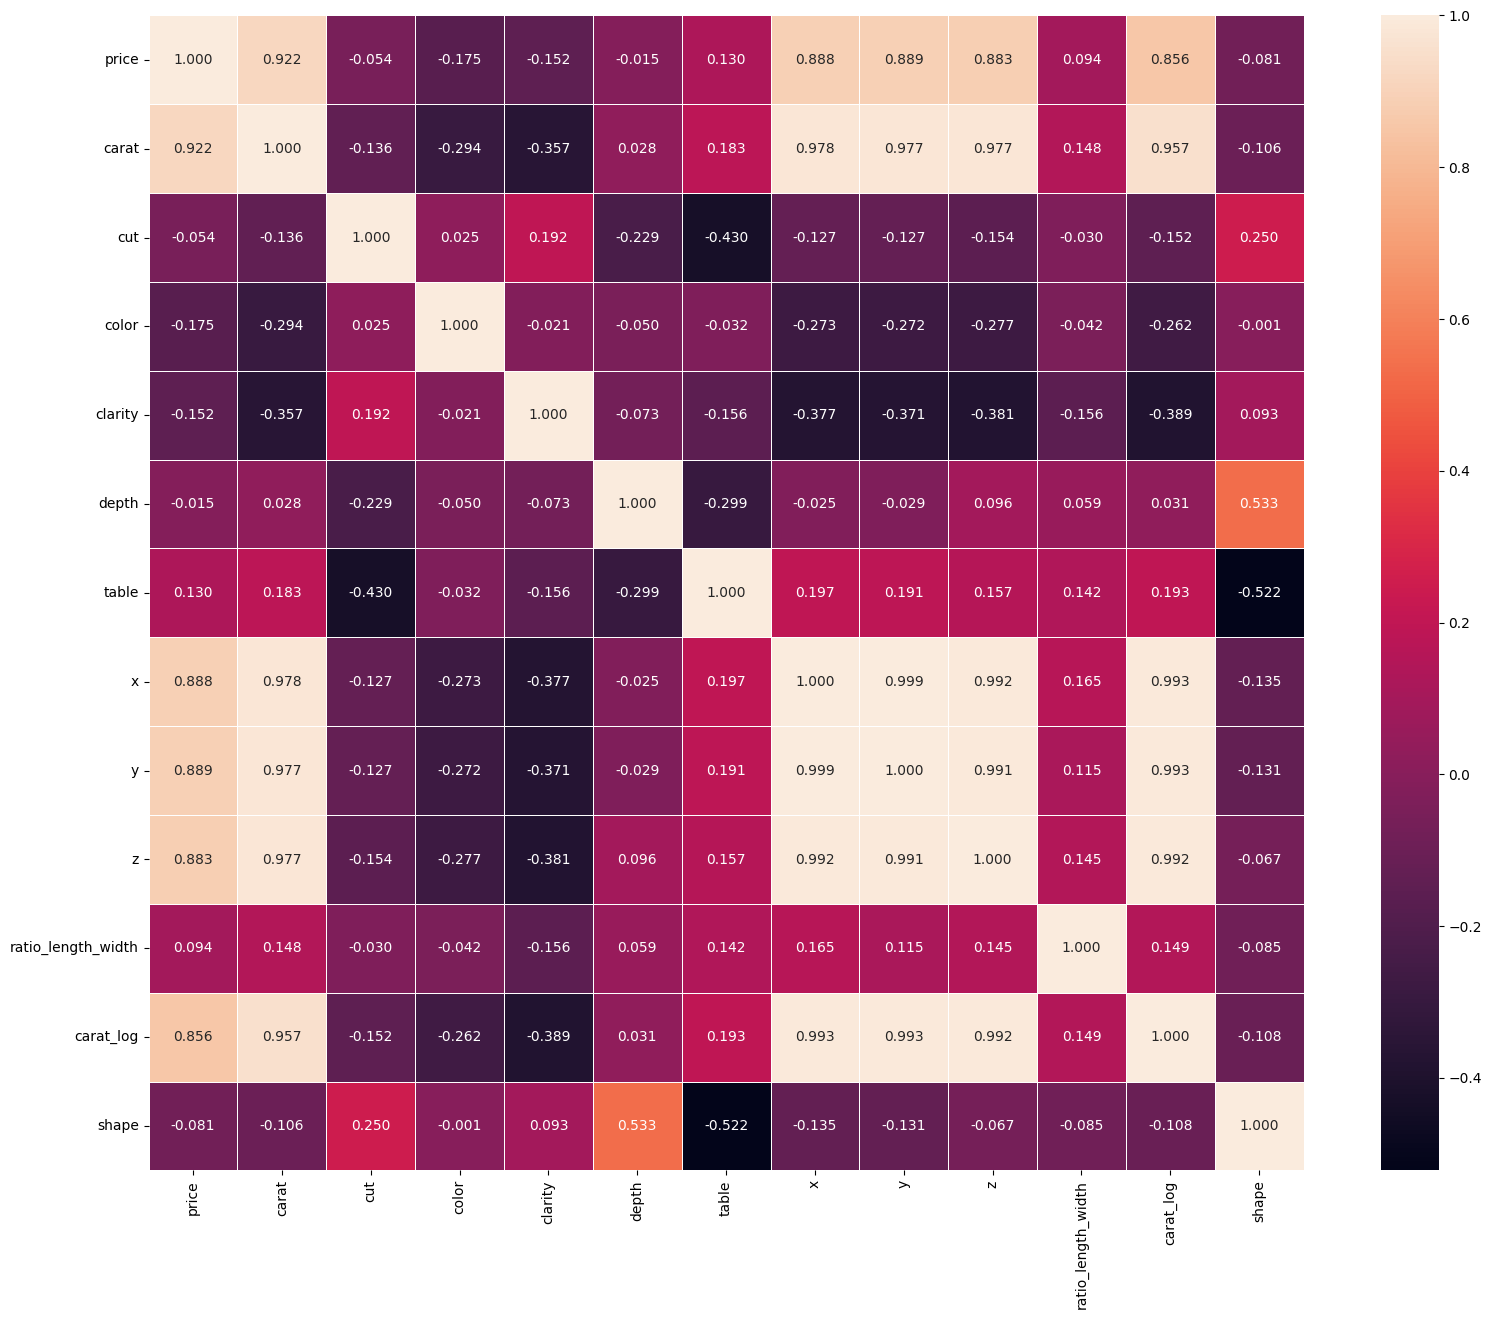

In [36]:
plt.subplots(figsize = (20, 15))
corr = diamonds_train_sorted.corr()
sns.heatmap(data = corr, annot = True, fmt = ".3f", cbar = True, linewidth = .5, 
            annot_kws = {'fontsize':10, 'fontweight':'regular'}, square = True)

# Model train split

In [37]:
X = diamonds_train_sorted[['cut',
                           'color', 
                           'clarity',
                           'ratio_length_width',
                           'carat_log',
                           'shape']]

y = diamonds_train_sorted['price']

In [38]:
"""
# Train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")
"""

'\n# Train + test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)\nprint(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")\nprint(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")\n'

# Scaling robust

In [39]:
# Scaling robust 100 % model 
scaler_rs = RobustScaler()
scaling_X_rs = scaler_rs.fit_transform(X)
scaled_X_rs = pd.DataFrame(scaling_X_rs)
scaled_X_rs

,0,1,2,3,4,5
0,0.0,0.666667,-0.5,1.206890,-1.260030,-3.0
1,0.5,0.666667,-1.0,-0.228548,-1.164822,1.0
2,-1.0,0.666667,0.5,-0.045357,-1.164822,-4.0
3,0.0,-0.666667,0.0,-0.197443,-0.922228,0.0
4,-1.0,-1.000000,-1.0,0.137238,-0.852431,0.0
...,...,...,...,...,...,...
40426,0.0,-0.333333,-0.5,1.056684,1.119426,-3.0
40427,0.0,-0.666667,-0.5,0.876156,1.240411,0.0
40428,0.5,0.000000,2.0,-0.079159,0.804579,1.0
40429,-0.5,0.000000,-0.5,-0.315494,1.098702,0.0


In [40]:
"""
# Scaling robust
scaler_r = RobustScaler()
scaling_X_train_r = scaler_r.fit_transform(X_train)
scaling_X_test_r = scaler_r.fit_transform(X_test)
scaled_X_train_r = pd.DataFrame(scaling_X_train_r)
scaled_X_train_r
"""

'\n# Scaling robust\nscaler_r = RobustScaler()\nscaling_X_train_r = scaler_r.fit_transform(X_train)\nscaling_X_test_r = scaler_r.fit_transform(X_test)\nscaled_X_train_r = pd.DataFrame(scaling_X_train_r)\nscaled_X_train_r\n'

In [41]:
"""
scaled_X_test_r = pd.DataFrame(scaling_X_test_r)
scaled_X_test_r
"""

'\nscaled_X_test_r = pd.DataFrame(scaling_X_test_r)\nscaled_X_test_r\n'

# Scaling standard

In [42]:
"""
scaler = StandardScaler()
scaling_X_train = scaler.fit_transform(X_train)
scaling_X_test = scaler.fit_transform(X_test)
scaled_X_train = pd.DataFrame(scaling_X_train)
scaled_X_train
"""

'\nscaler = StandardScaler()\nscaling_X_train = scaler.fit_transform(X_train)\nscaling_X_test = scaler.fit_transform(X_test)\nscaled_X_train = pd.DataFrame(scaling_X_train)\nscaled_X_train\n'

In [43]:
"""
scaled_X_test = pd.DataFrame(scaling_X_test)
scaled_X_test
"""

'\nscaled_X_test = pd.DataFrame(scaling_X_test)\nscaled_X_test\n'

# Train model CatBoost

In [44]:
"""
# rf model train
train_dataset = cb.Pool(scaled_X_train_r, y_train) 
test_dataset = cb.Pool(scaled_X_test_r, y_test)
"""

'\n# rf model train\ntrain_dataset = cb.Pool(scaled_X_train_r, y_train) \ntest_dataset = cb.Pool(scaled_X_test_r, y_test)\n'

In [45]:
model = GradientBoostingRegressor()
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
# execute the grid search
grid_result = grid_search.fit(X, y)

In [27]:
"""
model = GradientBoostingRegressor()
parameters_grid = {'n_estimators': 10,
        'loss': 'ls',
        'max_features': 'auto',
        'random_state':123}
"""

In [46]:
"""
grid_search = GridSearchCV(model,
              parameters_grid,
              cv = 5,
              verbose = 3,
              scoring = 'neg_root_mean_squared_error')
grid_search.fit(scaled_X_rs, y)
"""

"\ngrid_search = GridSearchCV(model,\n              parameters_grid,\n              cv = 5,\n              verbose = 3,\n              scoring = 'neg_root_mean_squared_error')\ngrid_search.fit(scaled_X_rs, y)\n"

In [47]:
best_model = grid_search.best_estimator_

In [ ]:
"""
# Predict model
y_pred = model.predict(scaled_X_test_r)
"""

In [ ]:
"""
# RMSE calculation
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse
"""

# Scaling robust 100 % model 

In [ ]:
"""
# Scaling robust 100 % model 
scaler_rs = RobustScaler()
scaling_X_rs = scaler_rs.fit_transform(X)
scaled_X_rs = pd.DataFrame(scaling_X_rs)
scaled_X_rs
"""

# Scaling standard 100 % model 

In [ ]:
"""
scaler = StandardScaler()
scaling_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaling_X)
scaled_X
"""

# Model train 100 % CatBoost

In [ ]:
"""
model.fit(scaled_X_rs, y)
"""

# Read diamonds_test_processed

In [48]:
# Read diamonds_test_processed
diamonds_test_basic = pd.read_csv('../data/diamonds_test_processed.csv')
diamonds_test_basic.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.79,2,4,2,62.7,60.0,5.82,5.89,3.67
1,1.20,4,0,4,61.0,57.0,6.81,6.89,4.18
2,1.57,3,2,2,62.2,61.0,7.38,7.32,4.57
3,0.90,2,4,2,63.8,54.0,6.09,6.13,3.90
4,0.50,2,4,4,62.9,58.0,5.05,5.09,3.19


# Feature engineering

In [49]:
#diamonds_test_basic['volume'] = diamonds_test_basic['x']*diamonds_test_basic['y']*diamonds_test_basic['z']
#diamonds_test_basic['dtc'] = diamonds_test_basic['depth'] / diamonds_test_basic['table'] * diamonds_test_basic['carat']
diamonds_test_basic['ratio_length_width'] = diamonds_test_basic['x']/diamonds_test_basic['y']
diamonds_test_basic.head()

,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width
0,0.79,2,4,2,62.7,60.0,5.82,5.89,3.67,0.988115
1,1.20,4,0,4,61.0,57.0,6.81,6.89,4.18,0.988389
2,1.57,3,2,2,62.2,61.0,7.38,7.32,4.57,1.008197
3,0.90,2,4,2,63.8,54.0,6.09,6.13,3.90,0.993475
4,0.50,2,4,4,62.9,58.0,5.05,5.09,3.19,0.992141


In [50]:
carat_log= []
for i in diamonds_test_basic['carat']:
    carat_log.append(math.log(i))
diamonds_test_basic['carat_log'] = carat_log
diamonds_test_basic.head()

,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width,carat_log
0,0.79,2,4,2,62.7,60.0,5.82,5.89,3.67,0.988115,-0.235722
1,1.20,4,0,4,61.0,57.0,6.81,6.89,4.18,0.988389,0.182322
2,1.57,3,2,2,62.2,61.0,7.38,7.32,4.57,1.008197,0.451076
3,0.90,2,4,2,63.8,54.0,6.09,6.13,3.90,0.993475,-0.105361
4,0.50,2,4,4,62.9,58.0,5.05,5.09,3.19,0.992141,-0.693147


# Create diamond shape

In [51]:
shape = []
for i in diamonds_test_basic['table'].index:
    if 54<diamonds_test_basic['table'][i]<57 and 59<diamonds_test_basic['depth'][i]<62.6:
        shape.append('Round')
    elif diamonds_test_basic['table'][i]<68 and 61<diamonds_test_basic['depth'][i]<68:
        shape.append('Cushion')
    elif 69<diamonds_test_basic['table'][i]<75 and 68<diamonds_test_basic['depth'][i]<74:
        shape.append('Princess')
    elif 60<diamonds_test_basic['table'][i]<68 and 61<diamonds_test_basic['depth'][i]<68:
        shape.append('Emerald')    
    elif 53<diamonds_test_basic['table'][i]<65 and diamonds_test_basic['depth'][i]<68:
        shape.append('Oval')
    elif 61<diamonds_test_basic['table'][i]<69 and diamonds_test_basic['depth'][i]<67:
        shape.append('Radiant')
    elif 53<diamonds_test_basic['table'][i]<63 and 56<diamonds_test_basic['depth'][i]<62:
        shape.append('Heart')   
    else:
        shape.append('others')

In [52]:
diamonds_test_basic['shape'] = shape
diamonds_test_basic.head()

,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width,carat_log,shape
0,0.79,2,4,2,62.7,60.0,5.82,5.89,3.67,0.988115,-0.235722,Cushion
1,1.20,4,0,4,61.0,57.0,6.81,6.89,4.18,0.988389,0.182322,Oval
2,1.57,3,2,2,62.2,61.0,7.38,7.32,4.57,1.008197,0.451076,Cushion
3,0.90,2,4,2,63.8,54.0,6.09,6.13,3.90,0.993475,-0.105361,Cushion
4,0.50,2,4,4,62.9,58.0,5.05,5.09,3.19,0.992141,-0.693147,Cushion


# Shape label encoding

In [53]:
diamonds_test_basic['shape']=diamonds_test_basic['shape'].map({'Round':7, 'Cushion':6, 'Princess': 5, 
                                                     'Emerald':4,'Oval': 3, 'Radiant': 2,
                                                  'Heart': 1, 'others':0})
diamonds_test_basic.head()

,carat,cut,color,clarity,depth,table,x,y,z,ratio_length_width,carat_log,shape
0,0.79,2,4,2,62.7,60.0,5.82,5.89,3.67,0.988115,-0.235722,6
1,1.20,4,0,4,61.0,57.0,6.81,6.89,4.18,0.988389,0.182322,3
2,1.57,3,2,2,62.2,61.0,7.38,7.32,4.57,1.008197,0.451076,6
3,0.90,2,4,2,63.8,54.0,6.09,6.13,3.90,0.993475,-0.105361,6
4,0.50,2,4,4,62.9,58.0,5.05,5.09,3.19,0.992141,-0.693147,6


# Predict diamonds_test_basic

In [54]:
# Define fearures
X_dtfe_2 = diamonds_test_basic[['cut',
                           'color', 
                           'clarity',
                           'ratio_length_width',
                           'carat_log',
                           'shape']]

# Scaling test robust

In [55]:
# Scaling model 
scaler_dtsr = RobustScaler()
scaling_X_dtsr = scaler_dtsr.fit_transform(X_dtfe_2)
scaled_X_dtsr = pd.DataFrame(scaling_X_dtsr)
scaled_X_dtsr

,0,1,2,3,4,5
0,-0.5,0.333333,-0.5,-0.535111,0.126584,0.0
1,0.5,-1.000000,0.5,-0.516017,0.564092,-3.0
2,0.0,-0.333333,-0.5,0.866783,0.845359,0.0
3,-0.5,0.333333,-0.5,-0.160976,0.263016,0.0
4,-0.5,0.333333,0.5,-0.254052,-0.352138,0.0
...,...,...,...,...,...,...
13480,0.5,0.666667,-0.5,0.688232,-0.215009,1.0
13481,0.5,-0.666667,0.0,0.050893,0.014845,1.0
13482,0.5,0.333333,0.5,0.783605,0.000000,1.0
13483,-0.5,0.333333,-1.0,-0.179537,0.000000,-3.0


# Scaling diamonds_test_scaled_s

In [56]:
"""
# Scaling model 
scaler_dtss = StandardScaler()
scaling_X_dtss = scaler_dtss.fit_transform(X_dtfe_2)
scaled_X_dtss = pd.DataFrame(scaling_X_dtss)
scaled_X_dtss
"""

'\n# Scaling model \nscaler_dtss = StandardScaler()\nscaling_X_dtss = scaler_dtss.fit_transform(X_dtfe_2)\nscaled_X_dtss = pd.DataFrame(scaling_X_dtss)\nscaled_X_dtss\n'

# Predict CatBoost

In [57]:
y_pred = best_model.predict(scaled_X_dtsr)
y_pred

C:\Users\Marguis\miniconda3\envs\pm3_env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


array([2730.76775793, 6134.2850764 , 7312.50244775, ..., 2579.18027874,
       2579.18027874,  933.9097169 ])

# Create sample_submission

In [58]:
predictions_fe_2 = pd.DataFrame(y_pred).rename(columns = {0:'price'})
predictions_fe_2.index.names = ['id']
predictions_fe_2

,price
id,
0,2730.767758
1,6134.285076
2,7312.502448
3,3271.450690
4,996.587492
...,...
13480,1696.313390
13481,2691.089766
13482,2579.180279


In [59]:
predictions_fe_2.to_csv('../predictions/predictions_gridsearch_GradientBoosting.csv')